# Plot the magnitude of the gradient update at model initialization for a variety of Dropout levels.
We see that Dropout preferentially targets higher-order interactions and reduces the gradient update size for these higher-order interactions.
Reproduces Figure 2 in the paper.

In [1]:
import numpy as np
import tensorflow as tf
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras import Model, layers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

tf.keras.backend.set_floatx('float64')

class NeuralNet(Model):
    # Set layers.
    def __init__(self, dropout_p, weight_decay, n_hidden_1, n_hidden_2, n_hidden_3, n_hidden_4, n_hidden_5, n_hidden_6,
                 kernel_initializer='glorot_uniform'):
        super(NeuralNet, self).__init__()
        self.d0 = layers.Dropout(dropout_p)
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu,
                                kernel_initializer=kernel_initializer,
                                bias_initializer='zeros',
                                kernel_regularizer=l2(weight_decay))
        self.d1 = layers.Dropout(dropout_p)
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu,
                                kernel_initializer=kernel_initializer,
                                bias_initializer='zeros',
                                kernel_regularizer=l2(weight_decay))
        self.d2 = layers.Dropout(dropout_p)
        self.fc3 = layers.Dense(n_hidden_3, activation=tf.nn.relu,
                               kernel_initializer=kernel_initializer,
                               bias_initializer='zeros',
                               kernel_regularizer=l2(weight_decay))
        self.d3 = layers.Dropout(dropout_p)
        self.fc4 = layers.Dense(n_hidden_4, activation=tf.nn.relu,
                               kernel_initializer=kernel_initializer,
                               bias_initializer='zeros',
                               kernel_regularizer=l2(weight_decay))
        self.d4 = layers.Dropout(dropout_p)
        self.fc5 = layers.Dense(n_hidden_5, activation=tf.nn.relu,
                               kernel_initializer=kernel_initializer,
                               bias_initializer='zeros',
                               kernel_regularizer=l2(weight_decay))
        self.d5 = layers.Dropout(dropout_p)
        self.fc6 = layers.Dense(n_hidden_6, activation=tf.nn.relu,
                               kernel_initializer=kernel_initializer,
                               bias_initializer='zeros',
                               kernel_regularizer=l2(weight_decay))
        self.d6 = layers.Dropout(dropout_p)
        self.out = layers.Dense(1, activation=tf.identity,
                                kernel_initializer=kernel_initializer,
                                bias_initializer='zeros',
                               kernel_regularizer=l2(weight_decay))

    # Set forward pass.
    def call(self, x):
        output = self.out(
            self.d6(self.fc6(
            self.d5(self.fc5(
            self.d4(self.fc4(
                self.d3(self.fc3(
                    self.d2(self.fc2(
                self.d1(self.fc1(x)))))))))
                   ))))
        return tf.squeeze(output)

In [3]:
n_samples = 10000
n_features = 5

def gen_data(n_samples, n_features, n_interactions, eps=0.001):
    X = np.random.uniform(-1, 1, size=(n_samples, n_features))
    Y = np.random.normal(0, eps, size=(n_samples))
    for order, num in enumerate(n_interactions):
        order += 1
        for i in range(num):
            parts = np.random.choice(n_features, size=order, replace=False)
            intx = 10*X[:, parts[0]]
            for j in range(1, len(parts)):
                intx *= 10*X[:, parts[j]]
            Y += intx
    return X, Y

def mean_square(y_pred, y_true):
    return tf.reduce_sum(tf.pow(y_pred-y_true, 2)) / (2 * n_samples)

def run_optimization(model, variables, optimizer, X_train, Y_train):
    if variables is None:
        variables = model.trainable_variables
    with tf.GradientTape() as g:
        pred = model(X_train, training=True)
        loss = mean_square(pred, Y_train)
        gradients = g.gradient(loss, variables)
        #print(gradients)
        optimizer.apply_gradients(zip(gradients, variables))
        return gradients, [v.numpy() for v in variables]
            
all_grads = {}
max_order = 4
n_iters = 1000
for order in range(1, max_order+1):
    n_interactions = [0] * max_order
    n_interactions[order-1] = 1
    X_train, Y_train = gen_data(n_samples, n_features, n_interactions=n_interactions)
    
    for dropout in [0.0, 0.1, 0.25, 0.5]:
        for iteration in range(n_iters):
            print(order, dropout, iteration)
            model = NeuralNet(dropout, 1e-9, 200, 200, 200, 200, 200, 200)
            if dropout == 0.0:
                init_weights = model.get_weights()
            else:
                model.set_weights(init_weights)
            preds_before = model(X_train, training=False)
            optimizer = tf.optimizers.Adam(1e-4)
            run_optimization(model, None, optimizer, X_train, Y_train)
            preds_after = model(X_train, training=False)
            grads = np.abs(preds_after.numpy() - preds_before.numpy())
            try:
                all_grads[dropout][order].append(grads)
            except KeyError:
                try:
                    all_grads[dropout][order] = [grads]
                except KeyError:
                    all_grads[dropout] = {order: [grads]}

1 0.0 0
1 0.0 1
1 0.0 2
1 0.0 3
1 0.0 4
1 0.0 5
1 0.0 6
1 0.0 7
1 0.0 8
1 0.0 9
1 0.0 10
1 0.0 11
1 0.0 12
1 0.0 13
1 0.0 14
1 0.0 15
1 0.0 16
1 0.0 17
1 0.0 18
1 0.0 19
1 0.0 20
1 0.0 21
1 0.0 22
1 0.0 23
1 0.0 24
1 0.0 25
1 0.0 26
1 0.0 27
1 0.0 28
1 0.0 29
1 0.0 30
1 0.0 31
1 0.0 32
1 0.0 33
1 0.0 34
1 0.0 35
1 0.0 36
1 0.0 37
1 0.0 38
1 0.0 39
1 0.0 40
1 0.0 41
1 0.0 42
1 0.0 43
1 0.0 44
1 0.0 45
1 0.0 46
1 0.0 47
1 0.0 48
1 0.0 49
1 0.0 50
1 0.0 51
1 0.0 52
1 0.0 53
1 0.0 54
1 0.0 55
1 0.0 56
1 0.0 57
1 0.0 58
1 0.0 59
1 0.0 60
1 0.0 61
1 0.0 62
1 0.0 63
1 0.0 64
1 0.0 65
1 0.0 66
1 0.0 67
1 0.0 68
1 0.0 69
1 0.0 70
1 0.0 71
1 0.0 72
1 0.0 73
1 0.0 74
1 0.0 75
1 0.0 76
1 0.0 77
1 0.0 78
1 0.0 79
1 0.0 80
1 0.0 81
1 0.0 82
1 0.0 83
1 0.0 84
1 0.0 85
1 0.0 86
1 0.0 87
1 0.0 88
1 0.0 89
1 0.0 90
1 0.0 91
1 0.0 92
1 0.0 93
1 0.0 94
1 0.0 95
1 0.0 96
1 0.0 97
1 0.0 98
1 0.0 99
1 0.0 100
1 0.0 101
1 0.0 102
1 0.0 103
1 0.0 104
1 0.0 105
1 0.0 106
1 0.0 107
1 0.0 108
1 0.0 109
1 0.0 110


1 0.0 831
1 0.0 832
1 0.0 833
1 0.0 834
1 0.0 835
1 0.0 836
1 0.0 837
1 0.0 838
1 0.0 839
1 0.0 840
1 0.0 841
1 0.0 842
1 0.0 843
1 0.0 844
1 0.0 845
1 0.0 846
1 0.0 847
1 0.0 848
1 0.0 849
1 0.0 850
1 0.0 851
1 0.0 852
1 0.0 853
1 0.0 854
1 0.0 855
1 0.0 856
1 0.0 857
1 0.0 858
1 0.0 859
1 0.0 860
1 0.0 861
1 0.0 862
1 0.0 863
1 0.0 864
1 0.0 865
1 0.0 866
1 0.0 867
1 0.0 868
1 0.0 869
1 0.0 870
1 0.0 871
1 0.0 872
1 0.0 873
1 0.0 874
1 0.0 875
1 0.0 876
1 0.0 877
1 0.0 878
1 0.0 879
1 0.0 880
1 0.0 881
1 0.0 882
1 0.0 883
1 0.0 884
1 0.0 885
1 0.0 886
1 0.0 887
1 0.0 888
1 0.0 889
1 0.0 890
1 0.0 891
1 0.0 892
1 0.0 893
1 0.0 894
1 0.0 895
1 0.0 896
1 0.0 897
1 0.0 898
1 0.0 899
1 0.0 900
1 0.0 901
1 0.0 902
1 0.0 903
1 0.0 904
1 0.0 905
1 0.0 906
1 0.0 907
1 0.0 908
1 0.0 909
1 0.0 910
1 0.0 911
1 0.0 912
1 0.0 913
1 0.0 914
1 0.0 915
1 0.0 916
1 0.0 917
1 0.0 918
1 0.0 919
1 0.0 920
1 0.0 921
1 0.0 922
1 0.0 923
1 0.0 924
1 0.0 925
1 0.0 926
1 0.0 927
1 0.0 928
1 0.0 929
1 0.0 930


1 0.1 662
1 0.1 663
1 0.1 664
1 0.1 665
1 0.1 666
1 0.1 667
1 0.1 668
1 0.1 669
1 0.1 670
1 0.1 671
1 0.1 672
1 0.1 673
1 0.1 674
1 0.1 675
1 0.1 676
1 0.1 677
1 0.1 678
1 0.1 679
1 0.1 680
1 0.1 681
1 0.1 682
1 0.1 683
1 0.1 684
1 0.1 685
1 0.1 686
1 0.1 687
1 0.1 688
1 0.1 689
1 0.1 690
1 0.1 691
1 0.1 692
1 0.1 693
1 0.1 694
1 0.1 695
1 0.1 696
1 0.1 697
1 0.1 698
1 0.1 699
1 0.1 700
1 0.1 701
1 0.1 702
1 0.1 703
1 0.1 704
1 0.1 705
1 0.1 706
1 0.1 707
1 0.1 708
1 0.1 709
1 0.1 710
1 0.1 711
1 0.1 712
1 0.1 713
1 0.1 714
1 0.1 715
1 0.1 716
1 0.1 717
1 0.1 718
1 0.1 719
1 0.1 720
1 0.1 721
1 0.1 722
1 0.1 723
1 0.1 724
1 0.1 725
1 0.1 726
1 0.1 727
1 0.1 728
1 0.1 729
1 0.1 730
1 0.1 731
1 0.1 732
1 0.1 733
1 0.1 734
1 0.1 735
1 0.1 736
1 0.1 737
1 0.1 738
1 0.1 739
1 0.1 740
1 0.1 741
1 0.1 742
1 0.1 743
1 0.1 744
1 0.1 745
1 0.1 746
1 0.1 747
1 0.1 748
1 0.1 749
1 0.1 750
1 0.1 751
1 0.1 752
1 0.1 753
1 0.1 754
1 0.1 755
1 0.1 756
1 0.1 757
1 0.1 758
1 0.1 759
1 0.1 760
1 0.1 761


1 0.25 448
1 0.25 449
1 0.25 450
1 0.25 451
1 0.25 452
1 0.25 453
1 0.25 454
1 0.25 455
1 0.25 456
1 0.25 457
1 0.25 458
1 0.25 459
1 0.25 460
1 0.25 461
1 0.25 462
1 0.25 463
1 0.25 464
1 0.25 465
1 0.25 466
1 0.25 467
1 0.25 468
1 0.25 469
1 0.25 470
1 0.25 471
1 0.25 472
1 0.25 473
1 0.25 474
1 0.25 475
1 0.25 476
1 0.25 477
1 0.25 478
1 0.25 479
1 0.25 480
1 0.25 481
1 0.25 482
1 0.25 483
1 0.25 484
1 0.25 485
1 0.25 486
1 0.25 487
1 0.25 488
1 0.25 489
1 0.25 490
1 0.25 491
1 0.25 492
1 0.25 493
1 0.25 494
1 0.25 495
1 0.25 496
1 0.25 497
1 0.25 498
1 0.25 499
1 0.25 500
1 0.25 501
1 0.25 502
1 0.25 503
1 0.25 504
1 0.25 505
1 0.25 506
1 0.25 507
1 0.25 508
1 0.25 509
1 0.25 510
1 0.25 511
1 0.25 512
1 0.25 513
1 0.25 514
1 0.25 515
1 0.25 516
1 0.25 517
1 0.25 518
1 0.25 519
1 0.25 520
1 0.25 521
1 0.25 522
1 0.25 523
1 0.25 524
1 0.25 525
1 0.25 526
1 0.25 527
1 0.25 528
1 0.25 529
1 0.25 530
1 0.25 531
1 0.25 532
1 0.25 533
1 0.25 534
1 0.25 535
1 0.25 536
1 0.25 537
1 0.25 538

1 0.5 224
1 0.5 225
1 0.5 226
1 0.5 227
1 0.5 228
1 0.5 229
1 0.5 230
1 0.5 231
1 0.5 232
1 0.5 233
1 0.5 234
1 0.5 235
1 0.5 236
1 0.5 237
1 0.5 238
1 0.5 239
1 0.5 240
1 0.5 241
1 0.5 242
1 0.5 243
1 0.5 244
1 0.5 245
1 0.5 246
1 0.5 247
1 0.5 248
1 0.5 249
1 0.5 250
1 0.5 251
1 0.5 252
1 0.5 253
1 0.5 254
1 0.5 255
1 0.5 256
1 0.5 257
1 0.5 258
1 0.5 259
1 0.5 260
1 0.5 261
1 0.5 262
1 0.5 263
1 0.5 264
1 0.5 265
1 0.5 266
1 0.5 267
1 0.5 268
1 0.5 269
1 0.5 270
1 0.5 271
1 0.5 272
1 0.5 273
1 0.5 274
1 0.5 275
1 0.5 276
1 0.5 277
1 0.5 278
1 0.5 279
1 0.5 280
1 0.5 281
1 0.5 282
1 0.5 283
1 0.5 284
1 0.5 285
1 0.5 286
1 0.5 287
1 0.5 288
1 0.5 289
1 0.5 290
1 0.5 291
1 0.5 292
1 0.5 293
1 0.5 294
1 0.5 295
1 0.5 296
1 0.5 297
1 0.5 298
1 0.5 299
1 0.5 300
1 0.5 301
1 0.5 302
1 0.5 303
1 0.5 304
1 0.5 305
1 0.5 306
1 0.5 307
1 0.5 308
1 0.5 309
1 0.5 310
1 0.5 311
1 0.5 312
1 0.5 313
1 0.5 314
1 0.5 315
1 0.5 316
1 0.5 317
1 0.5 318
1 0.5 319
1 0.5 320
1 0.5 321
1 0.5 322
1 0.5 323


2 0.0 50
2 0.0 51
2 0.0 52
2 0.0 53
2 0.0 54
2 0.0 55
2 0.0 56
2 0.0 57
2 0.0 58
2 0.0 59
2 0.0 60
2 0.0 61
2 0.0 62
2 0.0 63
2 0.0 64
2 0.0 65
2 0.0 66
2 0.0 67
2 0.0 68
2 0.0 69
2 0.0 70
2 0.0 71
2 0.0 72
2 0.0 73
2 0.0 74
2 0.0 75
2 0.0 76
2 0.0 77
2 0.0 78
2 0.0 79
2 0.0 80
2 0.0 81
2 0.0 82
2 0.0 83
2 0.0 84
2 0.0 85
2 0.0 86
2 0.0 87
2 0.0 88
2 0.0 89
2 0.0 90
2 0.0 91
2 0.0 92
2 0.0 93
2 0.0 94
2 0.0 95
2 0.0 96
2 0.0 97
2 0.0 98
2 0.0 99
2 0.0 100
2 0.0 101
2 0.0 102
2 0.0 103
2 0.0 104
2 0.0 105
2 0.0 106
2 0.0 107
2 0.0 108
2 0.0 109
2 0.0 110
2 0.0 111
2 0.0 112
2 0.0 113
2 0.0 114
2 0.0 115
2 0.0 116
2 0.0 117
2 0.0 118
2 0.0 119
2 0.0 120
2 0.0 121
2 0.0 122
2 0.0 123
2 0.0 124
2 0.0 125
2 0.0 126
2 0.0 127
2 0.0 128
2 0.0 129
2 0.0 130
2 0.0 131
2 0.0 132
2 0.0 133
2 0.0 134
2 0.0 135
2 0.0 136
2 0.0 137
2 0.0 138
2 0.0 139
2 0.0 140
2 0.0 141
2 0.0 142
2 0.0 143
2 0.0 144
2 0.0 145
2 0.0 146
2 0.0 147
2 0.0 148
2 0.0 149
2 0.0 150
2 0.0 151
2 0.0 152
2 0.0 153
2 0.0 154


2 0.0 875
2 0.0 876
2 0.0 877
2 0.0 878
2 0.0 879
2 0.0 880
2 0.0 881
2 0.0 882
2 0.0 883
2 0.0 884
2 0.0 885
2 0.0 886
2 0.0 887
2 0.0 888
2 0.0 889
2 0.0 890
2 0.0 891
2 0.0 892
2 0.0 893
2 0.0 894
2 0.0 895
2 0.0 896
2 0.0 897
2 0.0 898
2 0.0 899
2 0.0 900
2 0.0 901
2 0.0 902
2 0.0 903
2 0.0 904
2 0.0 905
2 0.0 906
2 0.0 907
2 0.0 908
2 0.0 909
2 0.0 910
2 0.0 911
2 0.0 912
2 0.0 913
2 0.0 914
2 0.0 915
2 0.0 916
2 0.0 917
2 0.0 918
2 0.0 919
2 0.0 920
2 0.0 921
2 0.0 922
2 0.0 923
2 0.0 924
2 0.0 925
2 0.0 926
2 0.0 927
2 0.0 928
2 0.0 929
2 0.0 930
2 0.0 931
2 0.0 932
2 0.0 933
2 0.0 934
2 0.0 935
2 0.0 936
2 0.0 937
2 0.0 938
2 0.0 939
2 0.0 940
2 0.0 941
2 0.0 942
2 0.0 943
2 0.0 944
2 0.0 945
2 0.0 946
2 0.0 947
2 0.0 948
2 0.0 949
2 0.0 950
2 0.0 951
2 0.0 952
2 0.0 953
2 0.0 954
2 0.0 955
2 0.0 956
2 0.0 957
2 0.0 958
2 0.0 959
2 0.0 960
2 0.0 961
2 0.0 962
2 0.0 963
2 0.0 964
2 0.0 965
2 0.0 966
2 0.0 967
2 0.0 968
2 0.0 969
2 0.0 970
2 0.0 971
2 0.0 972
2 0.0 973
2 0.0 974


2 0.1 706
2 0.1 707
2 0.1 708
2 0.1 709
2 0.1 710
2 0.1 711
2 0.1 712
2 0.1 713
2 0.1 714
2 0.1 715
2 0.1 716
2 0.1 717
2 0.1 718
2 0.1 719
2 0.1 720
2 0.1 721
2 0.1 722
2 0.1 723
2 0.1 724
2 0.1 725
2 0.1 726
2 0.1 727
2 0.1 728
2 0.1 729
2 0.1 730
2 0.1 731
2 0.1 732
2 0.1 733
2 0.1 734
2 0.1 735
2 0.1 736
2 0.1 737
2 0.1 738
2 0.1 739
2 0.1 740
2 0.1 741
2 0.1 742
2 0.1 743
2 0.1 744
2 0.1 745
2 0.1 746
2 0.1 747
2 0.1 748
2 0.1 749
2 0.1 750
2 0.1 751
2 0.1 752
2 0.1 753
2 0.1 754
2 0.1 755
2 0.1 756
2 0.1 757
2 0.1 758
2 0.1 759
2 0.1 760
2 0.1 761
2 0.1 762
2 0.1 763
2 0.1 764
2 0.1 765
2 0.1 766
2 0.1 767
2 0.1 768
2 0.1 769
2 0.1 770
2 0.1 771
2 0.1 772
2 0.1 773
2 0.1 774
2 0.1 775
2 0.1 776
2 0.1 777
2 0.1 778
2 0.1 779
2 0.1 780
2 0.1 781
2 0.1 782
2 0.1 783
2 0.1 784
2 0.1 785
2 0.1 786
2 0.1 787
2 0.1 788
2 0.1 789
2 0.1 790
2 0.1 791
2 0.1 792
2 0.1 793
2 0.1 794
2 0.1 795
2 0.1 796
2 0.1 797
2 0.1 798
2 0.1 799
2 0.1 800
2 0.1 801
2 0.1 802
2 0.1 803
2 0.1 804
2 0.1 805


2 0.25 488
2 0.25 489
2 0.25 490
2 0.25 491
2 0.25 492
2 0.25 493
2 0.25 494
2 0.25 495
2 0.25 496
2 0.25 497
2 0.25 498
2 0.25 499
2 0.25 500
2 0.25 501
2 0.25 502
2 0.25 503
2 0.25 504
2 0.25 505
2 0.25 506
2 0.25 507
2 0.25 508
2 0.25 509
2 0.25 510
2 0.25 511
2 0.25 512
2 0.25 513
2 0.25 514
2 0.25 515
2 0.25 516
2 0.25 517
2 0.25 518
2 0.25 519
2 0.25 520
2 0.25 521
2 0.25 522
2 0.25 523
2 0.25 524
2 0.25 525
2 0.25 526
2 0.25 527
2 0.25 528
2 0.25 529
2 0.25 530
2 0.25 531
2 0.25 532
2 0.25 533
2 0.25 534
2 0.25 535
2 0.25 536
2 0.25 537
2 0.25 538
2 0.25 539
2 0.25 540
2 0.25 541
2 0.25 542
2 0.25 543
2 0.25 544
2 0.25 545
2 0.25 546
2 0.25 547
2 0.25 548
2 0.25 549
2 0.25 550
2 0.25 551
2 0.25 552
2 0.25 553
2 0.25 554
2 0.25 555
2 0.25 556
2 0.25 557
2 0.25 558
2 0.25 559
2 0.25 560
2 0.25 561
2 0.25 562
2 0.25 563
2 0.25 564
2 0.25 565
2 0.25 566
2 0.25 567
2 0.25 568
2 0.25 569
2 0.25 570
2 0.25 571
2 0.25 572
2 0.25 573
2 0.25 574
2 0.25 575
2 0.25 576
2 0.25 577
2 0.25 578

2 0.5 268
2 0.5 269
2 0.5 270
2 0.5 271
2 0.5 272
2 0.5 273
2 0.5 274
2 0.5 275
2 0.5 276
2 0.5 277
2 0.5 278
2 0.5 279
2 0.5 280
2 0.5 281
2 0.5 282
2 0.5 283
2 0.5 284
2 0.5 285
2 0.5 286
2 0.5 287
2 0.5 288
2 0.5 289
2 0.5 290
2 0.5 291
2 0.5 292
2 0.5 293
2 0.5 294
2 0.5 295
2 0.5 296
2 0.5 297
2 0.5 298
2 0.5 299
2 0.5 300
2 0.5 301
2 0.5 302
2 0.5 303
2 0.5 304
2 0.5 305
2 0.5 306
2 0.5 307
2 0.5 308
2 0.5 309
2 0.5 310
2 0.5 311
2 0.5 312
2 0.5 313
2 0.5 314
2 0.5 315
2 0.5 316
2 0.5 317
2 0.5 318
2 0.5 319
2 0.5 320
2 0.5 321
2 0.5 322
2 0.5 323
2 0.5 324
2 0.5 325
2 0.5 326
2 0.5 327
2 0.5 328
2 0.5 329
2 0.5 330
2 0.5 331
2 0.5 332
2 0.5 333
2 0.5 334
2 0.5 335
2 0.5 336
2 0.5 337
2 0.5 338
2 0.5 339
2 0.5 340
2 0.5 341
2 0.5 342
2 0.5 343
2 0.5 344
2 0.5 345
2 0.5 346
2 0.5 347
2 0.5 348
2 0.5 349
2 0.5 350
2 0.5 351
2 0.5 352
2 0.5 353
2 0.5 354
2 0.5 355
2 0.5 356
2 0.5 357
2 0.5 358
2 0.5 359
2 0.5 360
2 0.5 361
2 0.5 362
2 0.5 363
2 0.5 364
2 0.5 365
2 0.5 366
2 0.5 367


3 0.0 99
3 0.0 100
3 0.0 101
3 0.0 102
3 0.0 103
3 0.0 104
3 0.0 105
3 0.0 106
3 0.0 107
3 0.0 108
3 0.0 109
3 0.0 110
3 0.0 111
3 0.0 112
3 0.0 113
3 0.0 114
3 0.0 115
3 0.0 116
3 0.0 117
3 0.0 118
3 0.0 119
3 0.0 120
3 0.0 121
3 0.0 122
3 0.0 123
3 0.0 124
3 0.0 125
3 0.0 126
3 0.0 127
3 0.0 128
3 0.0 129
3 0.0 130
3 0.0 131
3 0.0 132
3 0.0 133
3 0.0 134
3 0.0 135
3 0.0 136
3 0.0 137
3 0.0 138
3 0.0 139
3 0.0 140
3 0.0 141
3 0.0 142
3 0.0 143
3 0.0 144
3 0.0 145
3 0.0 146
3 0.0 147
3 0.0 148
3 0.0 149
3 0.0 150
3 0.0 151
3 0.0 152
3 0.0 153
3 0.0 154
3 0.0 155
3 0.0 156
3 0.0 157
3 0.0 158
3 0.0 159
3 0.0 160
3 0.0 161
3 0.0 162
3 0.0 163
3 0.0 164
3 0.0 165
3 0.0 166
3 0.0 167
3 0.0 168
3 0.0 169
3 0.0 170
3 0.0 171
3 0.0 172
3 0.0 173
3 0.0 174
3 0.0 175
3 0.0 176
3 0.0 177
3 0.0 178
3 0.0 179
3 0.0 180
3 0.0 181
3 0.0 182
3 0.0 183
3 0.0 184
3 0.0 185
3 0.0 186
3 0.0 187
3 0.0 188
3 0.0 189
3 0.0 190
3 0.0 191
3 0.0 192
3 0.0 193
3 0.0 194
3 0.0 195
3 0.0 196
3 0.0 197
3 0.0 198
3

3 0.0 919
3 0.0 920
3 0.0 921
3 0.0 922
3 0.0 923
3 0.0 924
3 0.0 925
3 0.0 926
3 0.0 927
3 0.0 928
3 0.0 929
3 0.0 930
3 0.0 931
3 0.0 932
3 0.0 933
3 0.0 934
3 0.0 935
3 0.0 936
3 0.0 937
3 0.0 938
3 0.0 939
3 0.0 940
3 0.0 941
3 0.0 942
3 0.0 943
3 0.0 944
3 0.0 945
3 0.0 946
3 0.0 947
3 0.0 948
3 0.0 949
3 0.0 950
3 0.0 951
3 0.0 952
3 0.0 953
3 0.0 954
3 0.0 955
3 0.0 956
3 0.0 957
3 0.0 958
3 0.0 959
3 0.0 960
3 0.0 961
3 0.0 962
3 0.0 963
3 0.0 964
3 0.0 965
3 0.0 966
3 0.0 967
3 0.0 968
3 0.0 969
3 0.0 970
3 0.0 971
3 0.0 972
3 0.0 973
3 0.0 974
3 0.0 975
3 0.0 976
3 0.0 977
3 0.0 978
3 0.0 979
3 0.0 980
3 0.0 981
3 0.0 982
3 0.0 983
3 0.0 984
3 0.0 985
3 0.0 986
3 0.0 987
3 0.0 988
3 0.0 989
3 0.0 990
3 0.0 991
3 0.0 992
3 0.0 993
3 0.0 994
3 0.0 995
3 0.0 996
3 0.0 997
3 0.0 998
3 0.0 999
3 0.1 0
3 0.1 1
3 0.1 2
3 0.1 3
3 0.1 4
3 0.1 5
3 0.1 6
3 0.1 7
3 0.1 8
3 0.1 9
3 0.1 10
3 0.1 11
3 0.1 12
3 0.1 13
3 0.1 14
3 0.1 15
3 0.1 16
3 0.1 17
3 0.1 18
3 0.1 19
3 0.1 20
3 0.1 21
3 

3 0.1 750
3 0.1 751
3 0.1 752
3 0.1 753
3 0.1 754
3 0.1 755
3 0.1 756
3 0.1 757
3 0.1 758
3 0.1 759
3 0.1 760
3 0.1 761
3 0.1 762
3 0.1 763
3 0.1 764
3 0.1 765
3 0.1 766
3 0.1 767
3 0.1 768
3 0.1 769
3 0.1 770
3 0.1 771
3 0.1 772
3 0.1 773
3 0.1 774
3 0.1 775
3 0.1 776
3 0.1 777
3 0.1 778
3 0.1 779
3 0.1 780
3 0.1 781
3 0.1 782
3 0.1 783
3 0.1 784
3 0.1 785
3 0.1 786
3 0.1 787
3 0.1 788
3 0.1 789
3 0.1 790
3 0.1 791
3 0.1 792
3 0.1 793
3 0.1 794
3 0.1 795
3 0.1 796
3 0.1 797
3 0.1 798
3 0.1 799
3 0.1 800
3 0.1 801
3 0.1 802
3 0.1 803
3 0.1 804
3 0.1 805
3 0.1 806
3 0.1 807
3 0.1 808
3 0.1 809
3 0.1 810
3 0.1 811
3 0.1 812
3 0.1 813
3 0.1 814
3 0.1 815
3 0.1 816
3 0.1 817
3 0.1 818
3 0.1 819
3 0.1 820
3 0.1 821
3 0.1 822
3 0.1 823
3 0.1 824
3 0.1 825
3 0.1 826
3 0.1 827
3 0.1 828
3 0.1 829
3 0.1 830
3 0.1 831
3 0.1 832
3 0.1 833
3 0.1 834
3 0.1 835
3 0.1 836
3 0.1 837
3 0.1 838
3 0.1 839
3 0.1 840
3 0.1 841
3 0.1 842
3 0.1 843
3 0.1 844
3 0.1 845
3 0.1 846
3 0.1 847
3 0.1 848
3 0.1 849


3 0.25 528
3 0.25 529
3 0.25 530
3 0.25 531
3 0.25 532
3 0.25 533
3 0.25 534
3 0.25 535
3 0.25 536
3 0.25 537
3 0.25 538
3 0.25 539
3 0.25 540
3 0.25 541
3 0.25 542
3 0.25 543
3 0.25 544
3 0.25 545
3 0.25 546
3 0.25 547
3 0.25 548
3 0.25 549
3 0.25 550
3 0.25 551
3 0.25 552
3 0.25 553
3 0.25 554
3 0.25 555
3 0.25 556
3 0.25 557
3 0.25 558
3 0.25 559
3 0.25 560
3 0.25 561
3 0.25 562
3 0.25 563
3 0.25 564
3 0.25 565
3 0.25 566
3 0.25 567
3 0.25 568
3 0.25 569
3 0.25 570
3 0.25 571
3 0.25 572
3 0.25 573
3 0.25 574
3 0.25 575
3 0.25 576
3 0.25 577
3 0.25 578
3 0.25 579
3 0.25 580
3 0.25 581
3 0.25 582
3 0.25 583
3 0.25 584
3 0.25 585
3 0.25 586
3 0.25 587
3 0.25 588
3 0.25 589
3 0.25 590
3 0.25 591
3 0.25 592
3 0.25 593
3 0.25 594
3 0.25 595
3 0.25 596
3 0.25 597
3 0.25 598
3 0.25 599
3 0.25 600
3 0.25 601
3 0.25 602
3 0.25 603
3 0.25 604
3 0.25 605
3 0.25 606
3 0.25 607
3 0.25 608
3 0.25 609
3 0.25 610
3 0.25 611
3 0.25 612
3 0.25 613
3 0.25 614
3 0.25 615
3 0.25 616
3 0.25 617
3 0.25 618

3 0.5 312
3 0.5 313
3 0.5 314
3 0.5 315
3 0.5 316
3 0.5 317
3 0.5 318
3 0.5 319
3 0.5 320
3 0.5 321
3 0.5 322
3 0.5 323
3 0.5 324
3 0.5 325
3 0.5 326
3 0.5 327
3 0.5 328
3 0.5 329
3 0.5 330
3 0.5 331
3 0.5 332
3 0.5 333
3 0.5 334
3 0.5 335
3 0.5 336
3 0.5 337
3 0.5 338
3 0.5 339
3 0.5 340
3 0.5 341
3 0.5 342
3 0.5 343
3 0.5 344
3 0.5 345
3 0.5 346
3 0.5 347
3 0.5 348
3 0.5 349
3 0.5 350
3 0.5 351
3 0.5 352
3 0.5 353
3 0.5 354
3 0.5 355
3 0.5 356
3 0.5 357
3 0.5 358
3 0.5 359
3 0.5 360
3 0.5 361
3 0.5 362
3 0.5 363
3 0.5 364
3 0.5 365
3 0.5 366
3 0.5 367
3 0.5 368
3 0.5 369
3 0.5 370
3 0.5 371
3 0.5 372
3 0.5 373
3 0.5 374
3 0.5 375
3 0.5 376
3 0.5 377
3 0.5 378
3 0.5 379
3 0.5 380
3 0.5 381
3 0.5 382
3 0.5 383
3 0.5 384
3 0.5 385
3 0.5 386
3 0.5 387
3 0.5 388
3 0.5 389
3 0.5 390
3 0.5 391
3 0.5 392
3 0.5 393
3 0.5 394
3 0.5 395
3 0.5 396
3 0.5 397
3 0.5 398
3 0.5 399
3 0.5 400
3 0.5 401
3 0.5 402
3 0.5 403
3 0.5 404
3 0.5 405
3 0.5 406
3 0.5 407
3 0.5 408
3 0.5 409
3 0.5 410
3 0.5 411


4 0.0 143
4 0.0 144
4 0.0 145
4 0.0 146
4 0.0 147
4 0.0 148
4 0.0 149
4 0.0 150
4 0.0 151
4 0.0 152
4 0.0 153
4 0.0 154
4 0.0 155
4 0.0 156
4 0.0 157
4 0.0 158
4 0.0 159
4 0.0 160
4 0.0 161
4 0.0 162
4 0.0 163
4 0.0 164
4 0.0 165
4 0.0 166
4 0.0 167
4 0.0 168
4 0.0 169
4 0.0 170
4 0.0 171
4 0.0 172
4 0.0 173
4 0.0 174
4 0.0 175
4 0.0 176
4 0.0 177
4 0.0 178
4 0.0 179
4 0.0 180
4 0.0 181
4 0.0 182
4 0.0 183
4 0.0 184
4 0.0 185
4 0.0 186
4 0.0 187
4 0.0 188
4 0.0 189
4 0.0 190
4 0.0 191
4 0.0 192
4 0.0 193
4 0.0 194
4 0.0 195
4 0.0 196
4 0.0 197
4 0.0 198
4 0.0 199
4 0.0 200
4 0.0 201
4 0.0 202
4 0.0 203
4 0.0 204
4 0.0 205
4 0.0 206
4 0.0 207
4 0.0 208
4 0.0 209
4 0.0 210
4 0.0 211
4 0.0 212
4 0.0 213
4 0.0 214
4 0.0 215
4 0.0 216
4 0.0 217
4 0.0 218
4 0.0 219
4 0.0 220
4 0.0 221
4 0.0 222
4 0.0 223
4 0.0 224
4 0.0 225
4 0.0 226
4 0.0 227
4 0.0 228
4 0.0 229
4 0.0 230
4 0.0 231
4 0.0 232
4 0.0 233
4 0.0 234
4 0.0 235
4 0.0 236
4 0.0 237
4 0.0 238
4 0.0 239
4 0.0 240
4 0.0 241
4 0.0 242


4 0.0 963
4 0.0 964
4 0.0 965
4 0.0 966
4 0.0 967
4 0.0 968
4 0.0 969
4 0.0 970
4 0.0 971
4 0.0 972
4 0.0 973
4 0.0 974
4 0.0 975
4 0.0 976
4 0.0 977
4 0.0 978
4 0.0 979
4 0.0 980
4 0.0 981
4 0.0 982
4 0.0 983
4 0.0 984
4 0.0 985
4 0.0 986
4 0.0 987
4 0.0 988
4 0.0 989
4 0.0 990
4 0.0 991
4 0.0 992
4 0.0 993
4 0.0 994
4 0.0 995
4 0.0 996
4 0.0 997
4 0.0 998
4 0.0 999
4 0.1 0
4 0.1 1
4 0.1 2
4 0.1 3
4 0.1 4
4 0.1 5
4 0.1 6
4 0.1 7
4 0.1 8
4 0.1 9
4 0.1 10
4 0.1 11
4 0.1 12
4 0.1 13
4 0.1 14
4 0.1 15
4 0.1 16
4 0.1 17
4 0.1 18
4 0.1 19
4 0.1 20
4 0.1 21
4 0.1 22
4 0.1 23
4 0.1 24
4 0.1 25
4 0.1 26
4 0.1 27
4 0.1 28
4 0.1 29
4 0.1 30
4 0.1 31
4 0.1 32
4 0.1 33
4 0.1 34
4 0.1 35
4 0.1 36
4 0.1 37
4 0.1 38
4 0.1 39
4 0.1 40
4 0.1 41
4 0.1 42
4 0.1 43
4 0.1 44
4 0.1 45
4 0.1 46
4 0.1 47
4 0.1 48
4 0.1 49
4 0.1 50
4 0.1 51
4 0.1 52
4 0.1 53
4 0.1 54
4 0.1 55
4 0.1 56
4 0.1 57
4 0.1 58
4 0.1 59
4 0.1 60
4 0.1 61
4 0.1 62
4 0.1 63
4 0.1 64
4 0.1 65
4 0.1 66
4 0.1 67
4 0.1 68
4 0.1 69
4 0.1 70
4

4 0.1 794
4 0.1 795
4 0.1 796
4 0.1 797
4 0.1 798
4 0.1 799
4 0.1 800
4 0.1 801
4 0.1 802
4 0.1 803
4 0.1 804
4 0.1 805
4 0.1 806
4 0.1 807
4 0.1 808
4 0.1 809
4 0.1 810
4 0.1 811
4 0.1 812
4 0.1 813
4 0.1 814
4 0.1 815
4 0.1 816
4 0.1 817
4 0.1 818
4 0.1 819
4 0.1 820
4 0.1 821
4 0.1 822
4 0.1 823
4 0.1 824
4 0.1 825
4 0.1 826
4 0.1 827
4 0.1 828
4 0.1 829
4 0.1 830
4 0.1 831
4 0.1 832
4 0.1 833
4 0.1 834
4 0.1 835
4 0.1 836
4 0.1 837
4 0.1 838
4 0.1 839
4 0.1 840
4 0.1 841
4 0.1 842
4 0.1 843
4 0.1 844
4 0.1 845
4 0.1 846
4 0.1 847
4 0.1 848
4 0.1 849
4 0.1 850
4 0.1 851
4 0.1 852
4 0.1 853
4 0.1 854
4 0.1 855
4 0.1 856
4 0.1 857
4 0.1 858
4 0.1 859
4 0.1 860
4 0.1 861
4 0.1 862
4 0.1 863
4 0.1 864
4 0.1 865
4 0.1 866
4 0.1 867
4 0.1 868
4 0.1 869
4 0.1 870
4 0.1 871
4 0.1 872
4 0.1 873
4 0.1 874
4 0.1 875
4 0.1 876
4 0.1 877
4 0.1 878
4 0.1 879
4 0.1 880
4 0.1 881
4 0.1 882
4 0.1 883
4 0.1 884
4 0.1 885
4 0.1 886
4 0.1 887
4 0.1 888
4 0.1 889
4 0.1 890
4 0.1 891
4 0.1 892
4 0.1 893


4 0.25 568
4 0.25 569
4 0.25 570
4 0.25 571
4 0.25 572
4 0.25 573
4 0.25 574
4 0.25 575
4 0.25 576
4 0.25 577
4 0.25 578
4 0.25 579
4 0.25 580
4 0.25 581
4 0.25 582
4 0.25 583
4 0.25 584
4 0.25 585
4 0.25 586
4 0.25 587
4 0.25 588
4 0.25 589
4 0.25 590
4 0.25 591
4 0.25 592
4 0.25 593
4 0.25 594
4 0.25 595
4 0.25 596
4 0.25 597
4 0.25 598
4 0.25 599
4 0.25 600
4 0.25 601
4 0.25 602
4 0.25 603
4 0.25 604
4 0.25 605
4 0.25 606
4 0.25 607
4 0.25 608
4 0.25 609
4 0.25 610
4 0.25 611
4 0.25 612
4 0.25 613
4 0.25 614
4 0.25 615
4 0.25 616
4 0.25 617
4 0.25 618
4 0.25 619
4 0.25 620
4 0.25 621
4 0.25 622
4 0.25 623
4 0.25 624
4 0.25 625
4 0.25 626
4 0.25 627
4 0.25 628
4 0.25 629
4 0.25 630
4 0.25 631
4 0.25 632
4 0.25 633
4 0.25 634
4 0.25 635
4 0.25 636
4 0.25 637
4 0.25 638
4 0.25 639
4 0.25 640
4 0.25 641
4 0.25 642
4 0.25 643
4 0.25 644
4 0.25 645
4 0.25 646
4 0.25 647
4 0.25 648
4 0.25 649
4 0.25 650
4 0.25 651
4 0.25 652
4 0.25 653
4 0.25 654
4 0.25 655
4 0.25 656
4 0.25 657
4 0.25 658

4 0.5 356
4 0.5 357
4 0.5 358
4 0.5 359
4 0.5 360
4 0.5 361
4 0.5 362
4 0.5 363
4 0.5 364
4 0.5 365
4 0.5 366
4 0.5 367
4 0.5 368
4 0.5 369
4 0.5 370
4 0.5 371
4 0.5 372
4 0.5 373
4 0.5 374
4 0.5 375
4 0.5 376
4 0.5 377
4 0.5 378
4 0.5 379
4 0.5 380
4 0.5 381
4 0.5 382
4 0.5 383
4 0.5 384
4 0.5 385
4 0.5 386
4 0.5 387
4 0.5 388
4 0.5 389
4 0.5 390
4 0.5 391
4 0.5 392
4 0.5 393
4 0.5 394
4 0.5 395
4 0.5 396
4 0.5 397
4 0.5 398
4 0.5 399
4 0.5 400
4 0.5 401
4 0.5 402
4 0.5 403
4 0.5 404
4 0.5 405
4 0.5 406
4 0.5 407
4 0.5 408
4 0.5 409
4 0.5 410
4 0.5 411
4 0.5 412
4 0.5 413
4 0.5 414
4 0.5 415
4 0.5 416
4 0.5 417
4 0.5 418
4 0.5 419
4 0.5 420
4 0.5 421
4 0.5 422
4 0.5 423
4 0.5 424
4 0.5 425
4 0.5 426
4 0.5 427
4 0.5 428
4 0.5 429
4 0.5 430
4 0.5 431
4 0.5 432
4 0.5 433
4 0.5 434
4 0.5 435
4 0.5 436
4 0.5 437
4 0.5 438
4 0.5 439
4 0.5 440
4 0.5 441
4 0.5 442
4 0.5 443
4 0.5 444
4 0.5 445
4 0.5 446
4 0.5 447
4 0.5 448
4 0.5 449
4 0.5 450
4 0.5 451
4 0.5 452
4 0.5 453
4 0.5 454
4 0.5 455


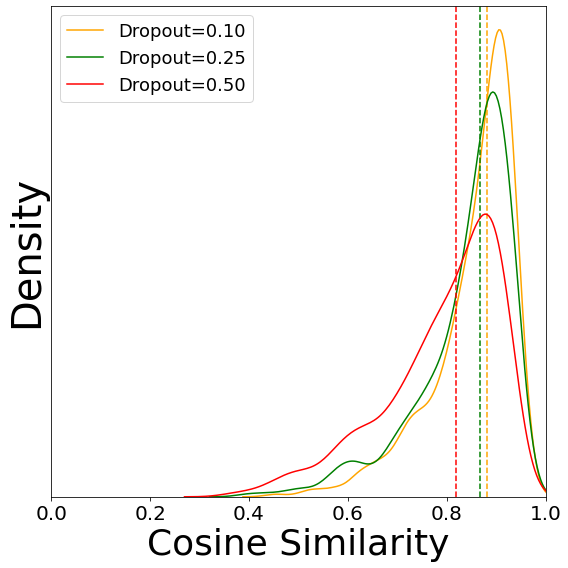

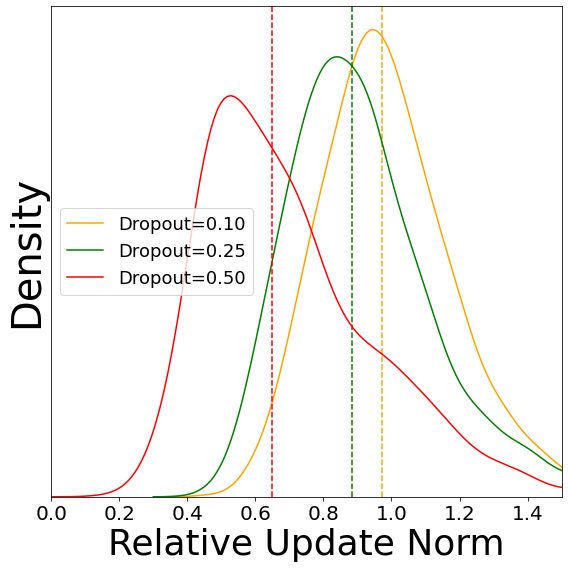

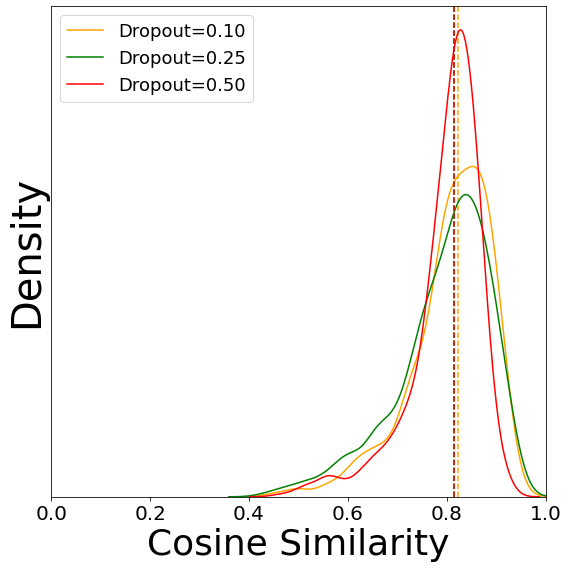

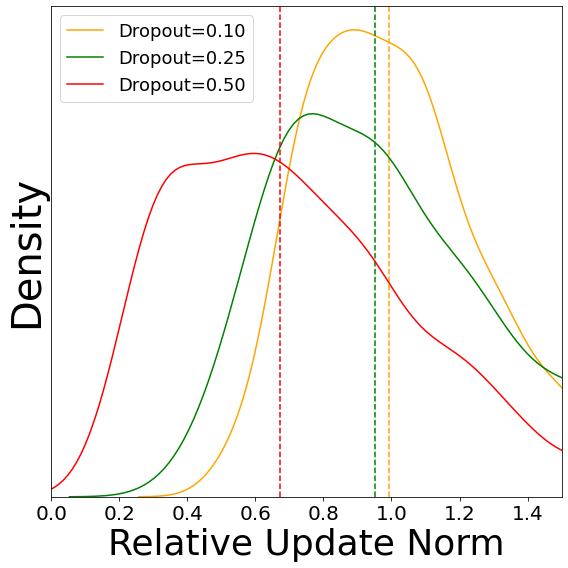

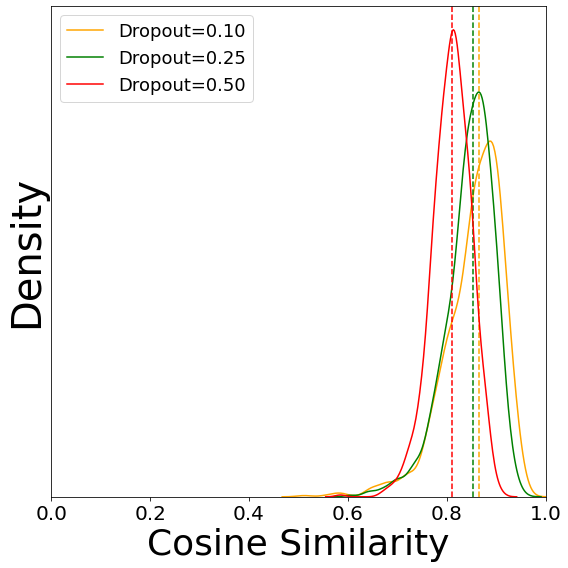

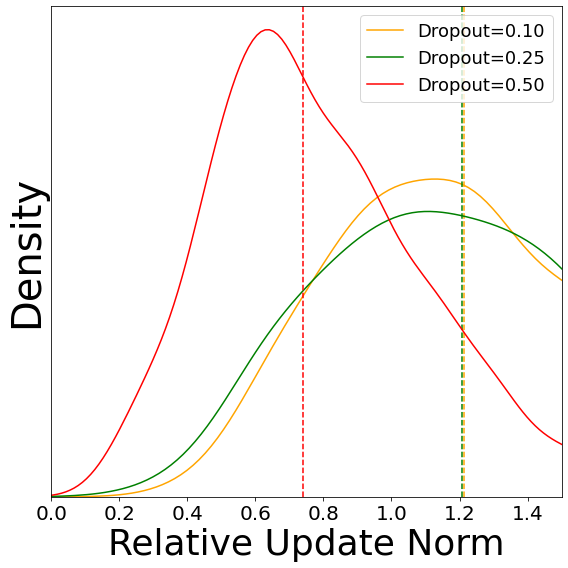

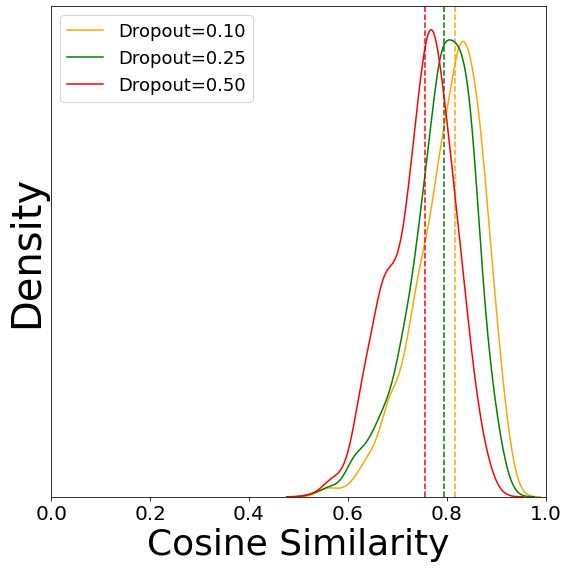

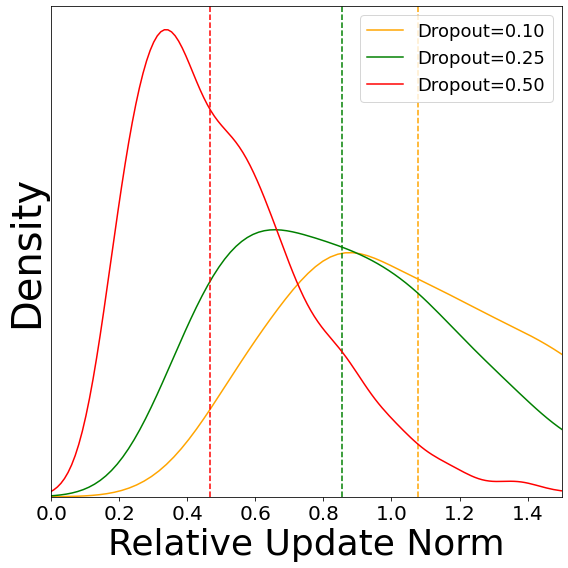

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

for order in range(1, max_order + 1):
    cosines = {0.1: [], 0.25: [], 0.5: []}
    norms = {0.1: [], 0.25: [], 0.5: []}
    for dropout in [0.1, 0.25, 0.5]:
        for iteration in range(n_iters):
            cosines[dropout].append(cos_sim(all_grads[dropout][order][iteration], all_grads[0.0][order][iteration]))
            norms[dropout].append(np.linalg.norm(all_grads[dropout][order][iteration]) /
                                  np.linalg.norm(all_grads[0.0][order][iteration]))

    # Histogram of cosine similarities with Dropout=0.0
    fig = plt.figure(figsize=(8,8))
    colors = {0.1: 'orange', 0.25: 'green', 0.5: 'red'}
    for dropout in cosines.keys():
        sns.kdeplot(cosines[dropout], label="Dropout={:.2f}".format(dropout), color=colors[dropout])
        plt.axvline(np.median(cosines[dropout]), color=colors[dropout], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.xlabel("Cosine Similarity", fontsize=36)
    plt.ylabel("Density", fontsize=40)
    plt.xticks(fontsize=20)
    plt.yticks([], fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig("results/grad_update_cosine_{}.pdf".format(order), dpi=300, bbox_inches='tight')
    # Histogram of magnitudes with Dropout=0.0

    fig = plt.figure(figsize=(8, 8))
    for dropout in norms.keys():
        sns.kdeplot(norms[dropout], label="Dropout={:.2f}".format(dropout), color=colors[dropout])
        plt.axvline(np.median(norms[dropout]), color=colors[dropout], linestyle='--')
    plt.xlabel("Relative Update Norm", fontsize=36)
    plt.ylabel("Density", fontsize=40)
    plt.xticks(fontsize=20)
    plt.xlim([0.0, 1.5])
    plt.yticks([], fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig("results/grad_update_norm_{}.pdf".format(order), dpi=300, bbox_inches='tight')